# EDA


In [11]:
# Import the required libraries
import pandas as pd
import numpy as np
import scipy.stats as scs
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

import us # cool package for easily working with US and state metadata: https://github.com/unitedstates/python-us

%matplotlib inline

In [102]:
usa_geo_regions_dict = {	'Alaska': 'West',
							'Alabama': 'Southeast',
							'Arizona': 'Southwest',
							'Arkansas': 'Southeast',
							'California': 'West',
							'Colorado': 'West',
							'Connecticut': 'Northeast',
							'District of Columbia': 'Northeast',
							'Delaware': 'Northeast',
							'Florida': 'Southeast',
							'Georgia': 'Southeast',
							'Hawaii': 'West',
							'Iowa': 'Midwest',
							'Idaho': 'West',
							'Illinois': 'Midwest',
							'Indiana': 'Midwest',
							'Kansas': 'Midwest',
							'Kentucky': 'Southeast',
							'Louisiana': 'Southeast',
							'Massachusetts': 'Northeast',
							'Maryland': 'Northeast',
							'Maine': 'Northeast',
							'Michigan': 'Midwest',
							'Minnesota': 'Midwest',
							'Missouri': 'Midwest',
							'Mississippi': 'Southeast',
							'Montana': 'West',
							'North Carolina': 'Southeast',
							'North Dakota': 'Midwest',
							'Nebraska': 'Midwest',
							'New Hampshire': 'Northeast',
							'New Jersey': 'Northeast',
							'New Mexico': 'Southwest',
							'Nevada': 'West',
							'New York': 'Northeast',
							'Ohio': 'Midwest',
							'Oklahoma': 'Southwest',
							'Oregon': 'West',
							'Pennsylvania': 'Northeast',
							'Rhode Island': 'Northeast',
							'South Carolina': 'Southeast',
							'South Dakota': 'Midwest',
							'Tennessee': 'Southeast',
							'Texas': 'Southwest',
							'Utah': 'West',
							'Virginia': 'Southeast',
							'Vermont': 'Northeast',
							'Washington': 'West',
							'Wisconsin': 'Midwest',
							'West Virginia': 'Southeast',
							'Wyoming': 'West',
                            'USA': 'General USA'
							}

#  Functions
def get_pretty_percent(x, y):
    ''' Get formatted percent '''
    percentage = round(x/y, 3)
    return str(percentage) + '% '


def get_loc_state(location):
    '''
    Apply a simple hueristic to extract out the US state name from the user location. 
    Will also detect\extract the term 'USA'
    '''
    if 'USA' in location.upper():
        return 'USA'
    else:
        chunks = location.split(',')
        last_element = chunks[-1]
        return last_element.replace('.', '').replace('(', '').replace(')', '').replace('/', ' ').replace('|', ' ').replace('&', ' ').strip().upper()

def get_loc_state_vetted(loc_state):
    '''
    Return the vetted US state name or 'USA' or 'NOT VETTED'
    '''
    if loc_state == 'USA':
        return loc_state
    else:
        # Uses the us package for easily working with US and state metadata
        lookup_result = us.states.lookup(loc_state)
        if lookup_result is None:
            vetted_state = 'NOT VETTED'
        else:
            vetted_state = lookup_result.name
        return vetted_state

def get_us_geographic_region_for_state(loc_state):
	'''
	Return the US geographic region for the given US state identifer
	'''
	region = usa_geo_regions_dict[loc_state]
	if region is None:
		region = 'Unknown'
	return region

def get_pretty_percent(x, y):
	'''
	Return a nicely formatted percentage
	'''
	percentage = round(x/y, 3)
	return "{:.2%}".format(percentage)

def plot_region_breakdown(region_name_groupby_tuple, unstack=False):
	''' 
	Plot the Region Breakdowns 
	'''
	region_name = region_name_groupby_tuple[0]
	region_groupby = region_name_groupby_tuple[1]
	region_color = region_name_groupby_tuple[2]
	region_groupby.sort_values(ascending=False, inplace=True)
	if unstack:
		region_groupby.unstack().plot.bar(fontsize=14, rot=45, alpha=0.95, figsize=(15,10))
	else:
		region_groupby.plot.bar(fontsize=14, rot=45, alpha=0.80, figsize=(16,12), color=region_color)
	plt.title('Breakdown of Tweets by State in the US ' + region_name, size='16')
	plt.xlabel('State',size=14)
	plt.ylabel('Number of Tweets',size=14)
	plt.yticks(size=12)
	plt.show()


sns.set(style='white', context='talk')

### Read in ALL data

In [103]:
combined_tweets = pd.read_csv('../data/all_tweets_combined.csv')
combined_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38392 entries, 0 to 38391
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        38392 non-null  int64 
 1   content           38392 non-null  object
 2   user_loc          38392 non-null  object
 3   user_screen_name  38392 non-null  object
 4   retweet_count     38392 non-null  int64 
 5   fav_count         38392 non-null  int64 
 6   created_at        38392 non-null  object
 7   char_count        38392 non-null  int64 
 8   sentiment_method  38392 non-null  object
 9   sentiment         38392 non-null  object
dtypes: int64(4), object(6)
memory usage: 2.9+ MB


In [14]:
combined_tweets.head()

,Unnamed: 0,content,user_loc,user_screen_name,retweet_count,fav_count,created_at,char_count,sentiment_method,sentiment
0,0,“Instructional Considerations for the 2020-21 ...,"Illinois, USA",Erik_Youngman,0,2,2020-08-02 00:10:26,276,tools,neutral
1,1,With all the uncertainty of what September wil...,"Lyndhurst, NJ",Renee_LoBue,0,0,2020-08-01 23:57:31,264,tools,positive
2,2,Check this out on Wakelet - Digital learning a...,"Cary, NC",SupriyaVasu,0,0,2020-08-01 23:20:38,133,tools,neutral
3,3,Happy Friendship Day!\n#rdnums #nagaland #kohi...,"Kohima, India",rdnums,2,1,2020-08-01 23:17:09,264,tools,positive
4,4,Beat the summer heat with over 400 cool games ...,"Providence, RI",ABCyaGames,0,2,2020-08-01 23:00:00,146,tools,positive


### Narrow down to ONLY locations in the United States
* Inspect the user_loc value (corresponds to the Location string the Twitter user included in their profile)
* Using the heuristic of looking for USA in the Location string __or__ a Location that ends in ', some_state_identifier'
    * Extract out the value found using the heuristic and store as __loc_state__
* Use the __us__ package to 'vet' the extracted state idenfier and store as __loc_state_vetted__
    * https://github.com/unitedstates/python-us



In [15]:
combined_tweets['loc_state'] = combined_tweets.apply(lambda row: get_loc_state(row['user_loc']), axis=1)
combined_tweets['loc_state_vetted'] = combined_tweets.apply(lambda row: get_loc_state_vetted(row['loc_state']), axis=1)
display(combined_tweets.head())

loc_state_series = pd.Series(combined_tweets['loc_state'].unique())
loc_state_series.to_csv('../data/unique_loc_states.csv')

loc_state_betted_series = pd.Series(combined_tweets['loc_state_vetted'].unique())
loc_state_betted_series.to_csv('../data/unique_VETTED_loc_states.csv')

,Unnamed: 0,content,user_loc,user_screen_name,retweet_count,fav_count,created_at,char_count,sentiment_method,sentiment,loc_state,loc_state_vetted
0,0,“Instructional Considerations for the 2020-21 ...,"Illinois, USA",Erik_Youngman,0,2,2020-08-02 00:10:26,276,tools,neutral,USA,USA
1,1,With all the uncertainty of what September wil...,"Lyndhurst, NJ",Renee_LoBue,0,0,2020-08-01 23:57:31,264,tools,positive,NJ,New Jersey
2,2,Check this out on Wakelet - Digital learning a...,"Cary, NC",SupriyaVasu,0,0,2020-08-01 23:20:38,133,tools,neutral,NC,North Carolina
3,3,Happy Friendship Day!\n#rdnums #nagaland #kohi...,"Kohima, India",rdnums,2,1,2020-08-01 23:17:09,264,tools,positive,INDIA,NOT VETTED
4,4,Beat the summer heat with over 400 cool games ...,"Providence, RI",ABCyaGames,0,2,2020-08-01 23:00:00,146,tools,positive,RI,Rhode Island


In [16]:
vetted_usa_tweets = combined_tweets[combined_tweets['loc_state_vetted'] != 'NOT VETTED']
vetted_usa_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30599 entries, 0 to 38391
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        30599 non-null  int64 
 1   content           30599 non-null  object
 2   user_loc          30599 non-null  object
 3   user_screen_name  30599 non-null  object
 4   retweet_count     30599 non-null  int64 
 5   fav_count         30599 non-null  int64 
 6   created_at        30599 non-null  object
 7   char_count        30599 non-null  int64 
 8   sentiment_method  30599 non-null  object
 9   sentiment         30599 non-null  object
 10  loc_state         30599 non-null  object
 11  loc_state_vetted  30599 non-null  object
dtypes: int64(4), object(8)
memory usage: 3.0+ MB


### Include United States Geographic Region for each vetted US Tweet

In [18]:
vetted_usa_tweets['region'] = vetted_usa_tweets.apply(lambda row: get_us_geographic_region_for_state(row['loc_state_vetted']), axis=1)
vetted_usa_tweets.head()

,Unnamed: 0,content,user_loc,user_screen_name,retweet_count,fav_count,created_at,char_count,sentiment_method,sentiment,loc_state,loc_state_vetted,region
0,0,“Instructional Considerations for the 2020-21 ...,"Illinois, USA",Erik_Youngman,0,2,2020-08-02 00:10:26,276,tools,neutral,USA,USA,General USA
1,1,With all the uncertainty of what September wil...,"Lyndhurst, NJ",Renee_LoBue,0,0,2020-08-01 23:57:31,264,tools,positive,NJ,New Jersey,Northeast
2,2,Check this out on Wakelet - Digital learning a...,"Cary, NC",SupriyaVasu,0,0,2020-08-01 23:20:38,133,tools,neutral,NC,North Carolina,Southeast
4,4,Beat the summer heat with over 400 cool games ...,"Providence, RI",ABCyaGames,0,2,2020-08-01 23:00:00,146,tools,positive,RI,Rhode Island,Northeast
5,5,Thanks Science for kids for the follow! Please...,"Boxford, MA",danieldowns,1,1,2020-08-01 20:38:08,229,tools,positive,MA,Massachusetts,Northeast


### Save the US Tweets to file and perform EDA for sentiment insights by region and state.

In [265]:
# SAVE this to file...we'll be diving deeper into this data, by region and by state.
vetted_usa_tweets.to_csv('../data/vetted_usa_tweets.csv')


## Question 1: What is the general sentiment breakdown for these Tweets?
How many/what percentage Positive/Negative/Neutral?

In [19]:
# What are the value counts for the 3 different sentiments?
vetted_usa_tweets['sentiment'].value_counts()

positive    22618
neutral      4708
negative     3273
Name: sentiment, dtype: int64

In [20]:
# How many/what percentage Positive/Negative/Neutral?
by_sentiment = vetted_usa_tweets.groupby(['sentiment'])['content'].count()
by_sentiment.sort_values(ascending=False, inplace=True)

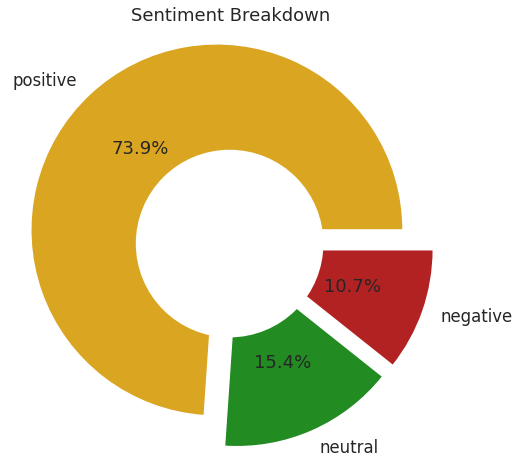

In [109]:
fig2, ax2 = plt.subplots(figsize=(8,8))

my_explode = (0.1, 0.1, 0.1)
my_colors = ['goldenrod','forestgreen', 'firebrick']
plt.pie(by_sentiment, labels=by_sentiment.index, autopct='%1.1f%%', shadow=False, 
        pctdistance=0.60, explode=my_explode, colors=my_colors)
plt.title('Sentiment Breakdown', size='18')

#draw circle and convert pie chart to Donut Chart
center_circle = plt.Circle((0,0),0.50,fc='white')
fig2 = plt.gcf()
fig2.gca().add_artist(center_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax2.axis('equal')  
plt.show()

## Question 1: Insights/Recommendations
There are _many_ more Tweets with Positive sentiment than Negative and Neutral combined. Recommendation is to address this class imblance in the Text Classifier modeling step. 

## Question 2a: What is the Breakdown of Tweets by US Geographic Region?

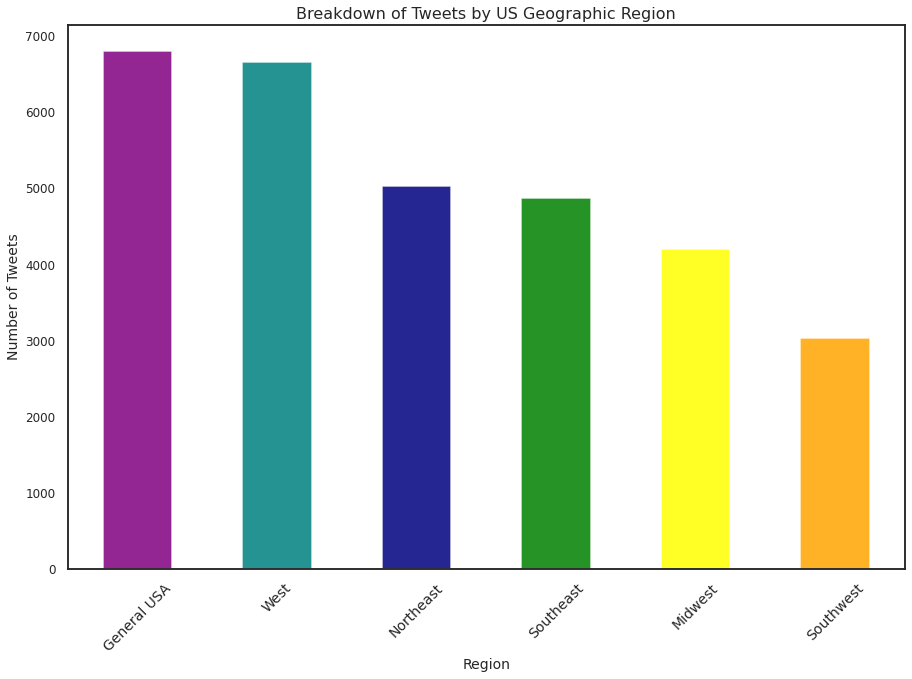

In [51]:
region_colors = ['purple', 'teal', 'navy', 'green', 'yellow', 'orange']
by_region = vetted_usa_tweets.groupby(['region'])['content'].count()
by_region.sort_values(ascending=False, inplace=True)
by_region.plot.bar(fontsize=14, rot=45, alpha=0.85, figsize=(15,10), color=region_colors)
plt.title('Breakdown of Tweets by US Geographic Region', size='16')
plt.xlabel('Region',size=14)
plt.ylabel('Number of Tweets',size=14)
plt.yticks(size=12)
plt.show()

## Question 2a: Insights/Recommendations:

ENTER

## Question 2b: What is the breakdown of Tweets by State in each Region?

In [48]:
northeast = vetted_usa_tweets[vetted_usa_tweets['region'] == 'Northeast']
southeast = vetted_usa_tweets[vetted_usa_tweets['region'] == 'Southeast']
southwest = vetted_usa_tweets[vetted_usa_tweets['region'] == 'Southwest']
west = vetted_usa_tweets[vetted_usa_tweets['region'] == 'West']
midwest = vetted_usa_tweets[vetted_usa_tweets['region'] == 'Midwest']
general_usa = vetted_usa_tweets[vetted_usa_tweets['region'] == 'General USA']

In [89]:
west_tweet_count = west.shape[0]
ne_tweet_count = northeast.shape[0]
se_tweet_count = southeast.shape[0]
mw_tweet_count = midwest.shape[0]
sw_tweet_count = southwest.shape[0]

In [66]:
northeast_by_state = northeast.groupby(['loc_state_vetted'])['content'].count()
southeast_by_state = southeast.groupby(['loc_state_vetted'])['content'].count()
southwest_by_state = southwest.groupby(['loc_state_vetted'])['content'].count()
west_by_state = west.groupby(['loc_state_vetted'])['content'].count()
midwest_by_state = midwest.groupby(['loc_state_vetted'])['content'].count()

regions_by_state_groupbys = [('West', west_by_state, 'teal'), 
                             ('Northeast', northeast_by_state, 'navy'), 
                             ('Southeast', southeast_by_state, 'green'), 
                             ('Midwest', midwest_by_state, 'yellow'),
                             ('Southwest', southwest_by_state, 'orange')]

northeast_by_state_and_sentiment = northeast.groupby(['loc_state_vetted', 'sentiment'])['content'].count()
southeast_by_state_and_sentiment = southeast.groupby(['loc_state_vetted', 'sentiment'])['content'].count()
southwest_by_state_and_sentiment = southwest.groupby(['loc_state_vetted', 'sentiment'])['content'].count()
west_by_state_and_sentiment = west.groupby(['loc_state_vetted', 'sentiment'])['content'].count()
midwest_by_state_and_sentiment = midwest.groupby(['loc_state_vetted', 'sentiment'])['content'].count()

regions_by_state_and_sentiment_groupbys = [('West', west_by_state_and_sentiment, 'teal'),
                                           ('Northeast', northeast_by_state_and_sentiment, 'navy'), 
                                           ('Southeast', southeast_by_state_and_sentiment, 'green'),
                                           ('Midwest', midwest_by_state_and_sentiment, 'yellow'),
                                           ('Southwest', southwest_by_state_and_sentiment, 'orange')]


In [95]:
print('------ Region: West -------')
for items in west_by_state.iteritems(): 
    print(get_pretty_percent(items[1], west_tweet_count), 'of Tweets from ' + items[0])
print('------ Region: Northeast -------')
for items in northeast_by_state.iteritems(): 
    print(get_pretty_percent(items[1], ne_tweet_count), 'of Tweets from ' + items[0])
print('------ Region: Southeast ------')
for items in southeast_by_state.iteritems(): 
    print(get_pretty_percent(items[1], se_tweet_count), 'of Tweets from ' + items[0])
print('------ Region: Midwest -------')
for items in midwest_by_state.iteritems(): 
    print(get_pretty_percent(items[1], mw_tweet_count), 'of Tweets from ' + items[0])
print('------ Region: Southwest -------')
for items in southwest_by_state.iteritems(): 
    print(get_pretty_percent(items[1], sw_tweet_count), 'of Tweets from ' + items[0])

------ Region: West -------
69.60% of Tweets from California
9.30% of Tweets from Washington
6.40% of Tweets from Colorado
4.30% of Tweets from Oregon
4.00% of Tweets from Nevada
2.60% of Tweets from Utah
1.50% of Tweets from Hawaii
1.10% of Tweets from Idaho
0.60% of Tweets from Montana
0.50% of Tweets from Alaska
0.30% of Tweets from Wyoming
------ Region: Northeast -------
30.40% of Tweets from New York
15.20% of Tweets from District of Columbia
15.10% of Tweets from Massachusetts
12.50% of Tweets from Pennsylvania
11.90% of Tweets from Maryland
5.80% of Tweets from New Jersey
3.40% of Tweets from Connecticut
1.60% of Tweets from New Hampshire
1.60% of Tweets from Rhode Island
1.10% of Tweets from Maine
1.00% of Tweets from Vermont
0.50% of Tweets from Delaware
------ Region: Southeast ------
23.00% of Tweets from Florida
15.40% of Tweets from Virginia
15.00% of Tweets from Georgia
13.20% of Tweets from North Carolina
10.60% of Tweets from Tennessee
5.00% of Tweets from Kentucky
4.4

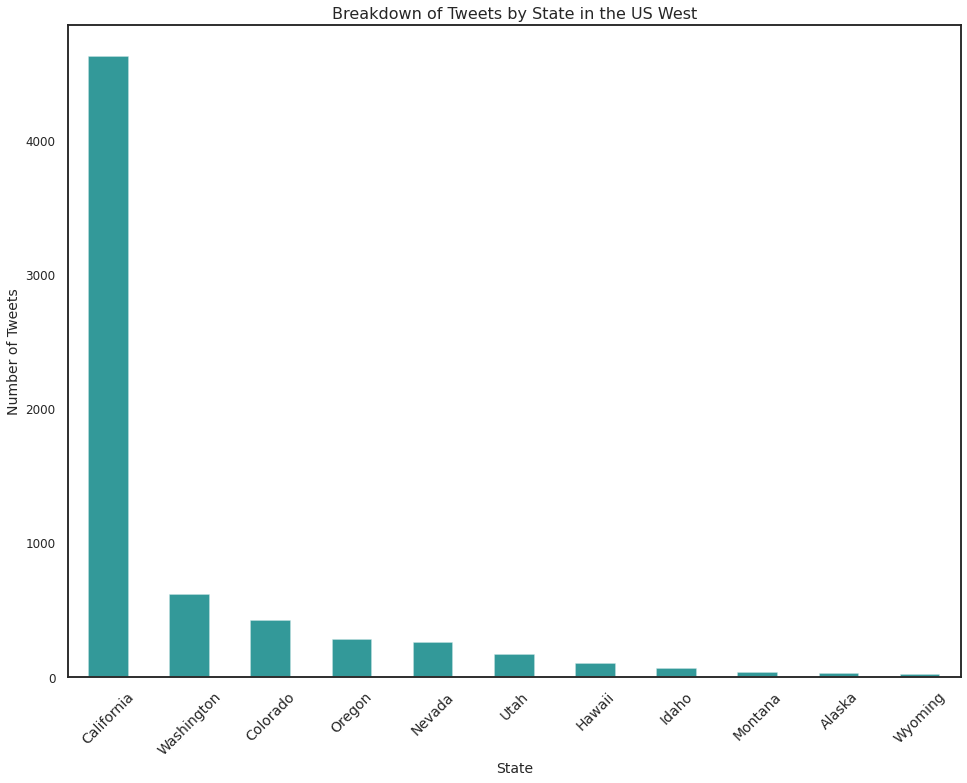

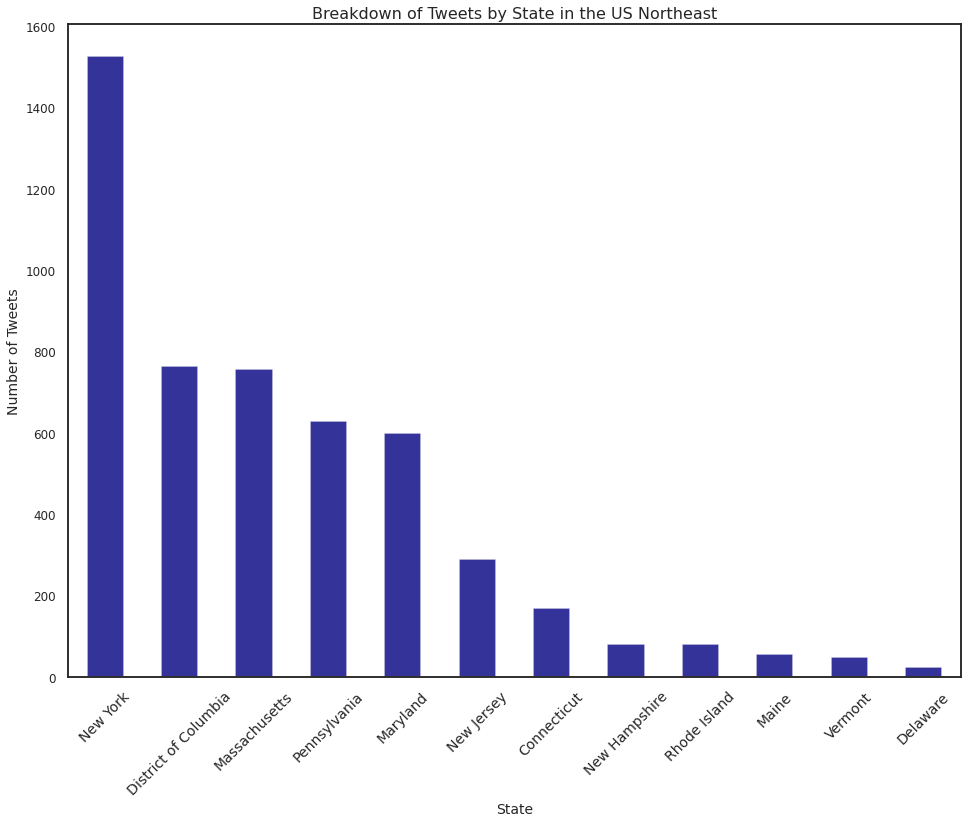

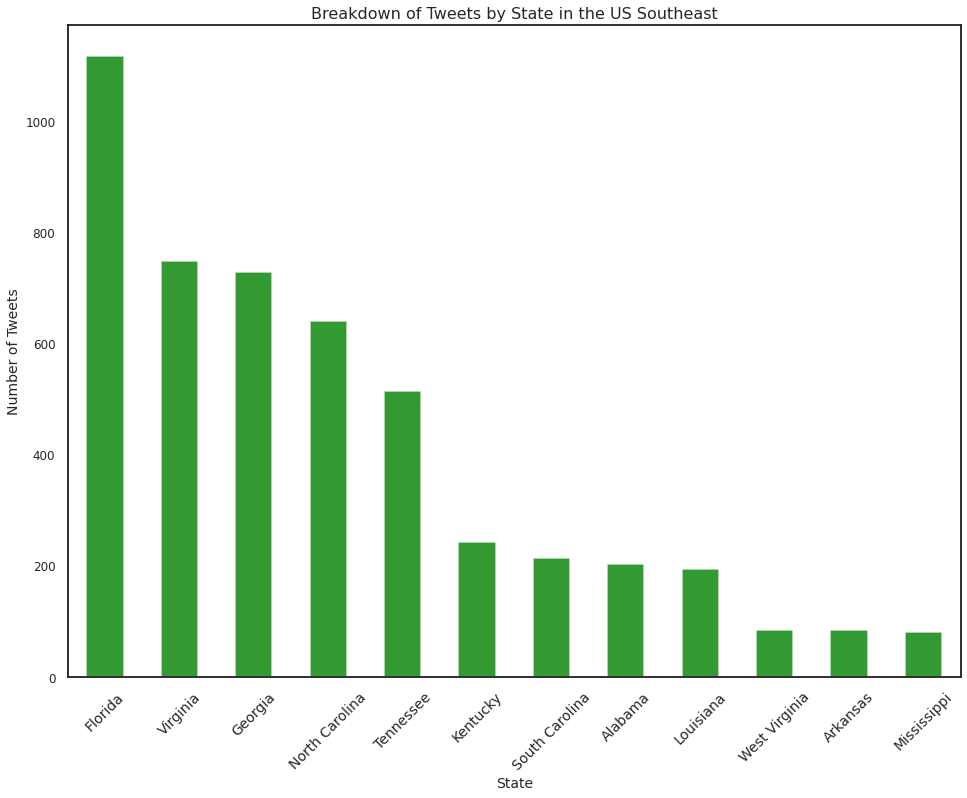

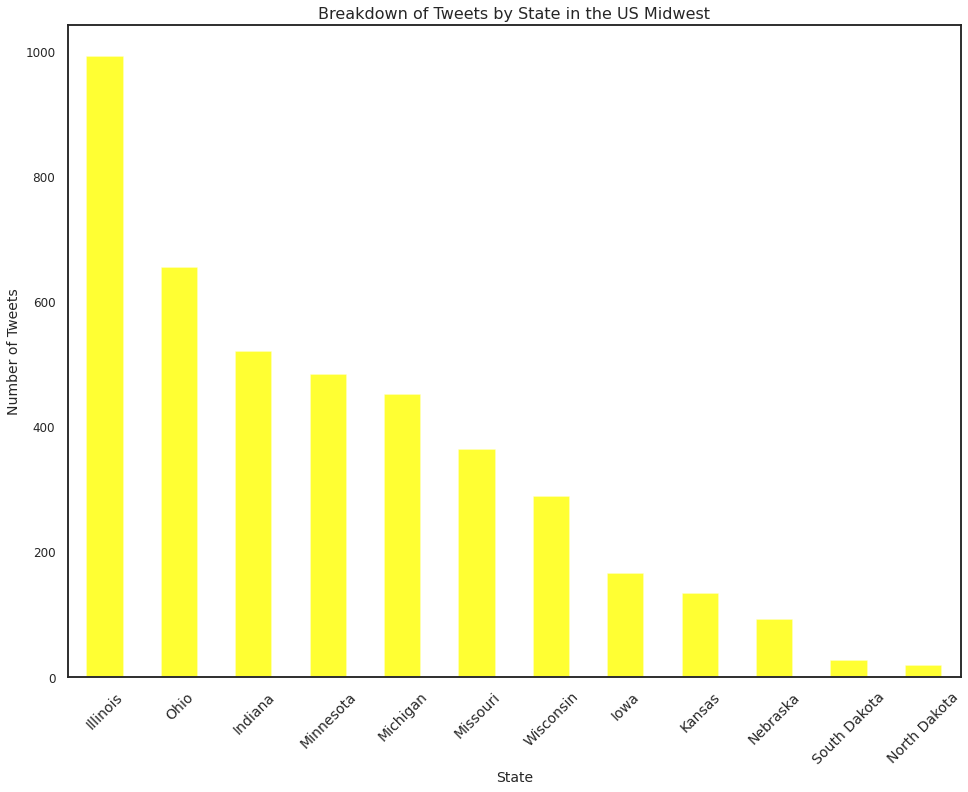

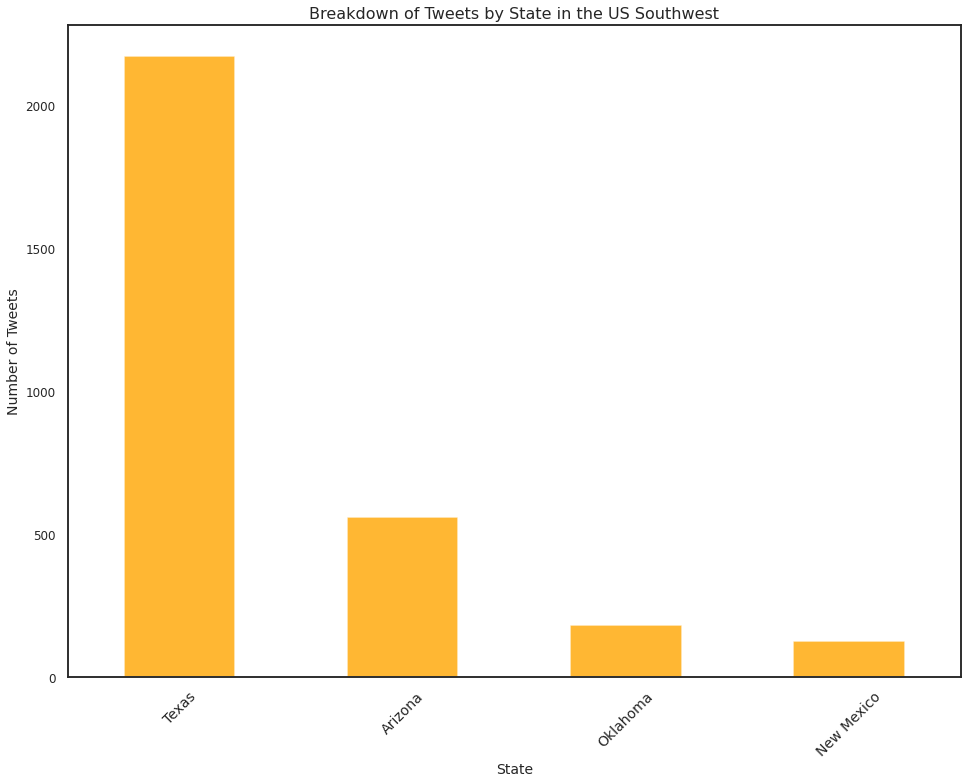

In [104]:
for item in regions_by_state_groupbys:
    plot_region_breakdown(item)

## Question 2b: Insights/Recommendations:

ENTER

## Question 3a: What is the Sentiment Breakdown of Tweets by US Geographic Region?

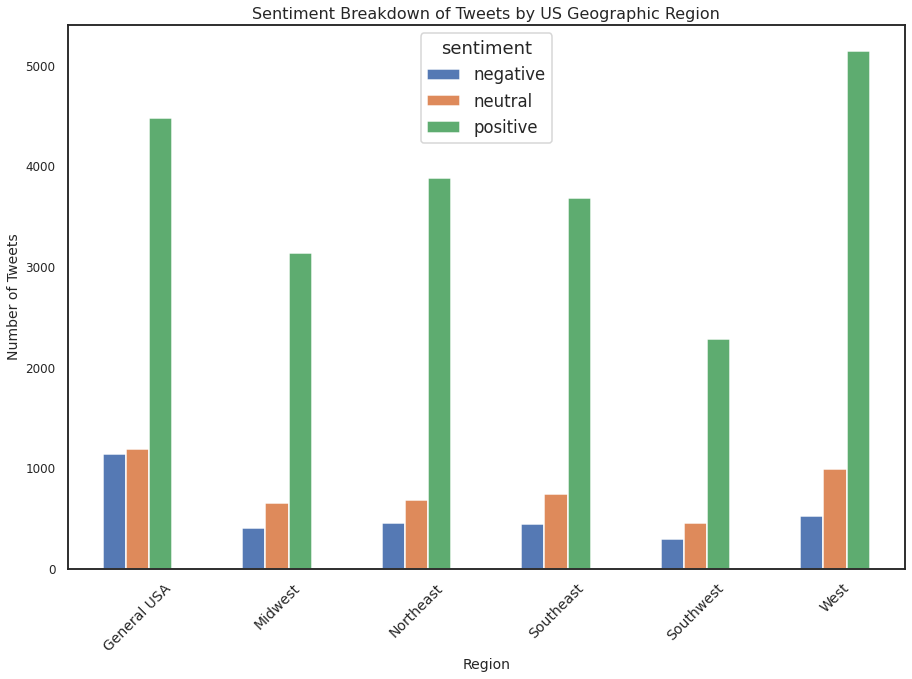

In [108]:
by_region_and_sentiment = vetted_usa_tweets.groupby(['region', 'sentiment'])['content'].count()

by_region_and_sentiment.unstack().plot.bar(fontsize=14, rot=45, alpha=0.95, figsize=(15,10))
plt.title('Sentiment Breakdown of Tweets by US Geographic Region', size='16')
plt.xlabel('Region',size=14)
plt.ylabel('Number of Tweets',size=14)
plt.yticks(size=12)
plt.show()

## Question 3a: Insights/Recommendations:

ENTER

## Question 3b: What is the Sentiment Breakdown by State for each US Region?

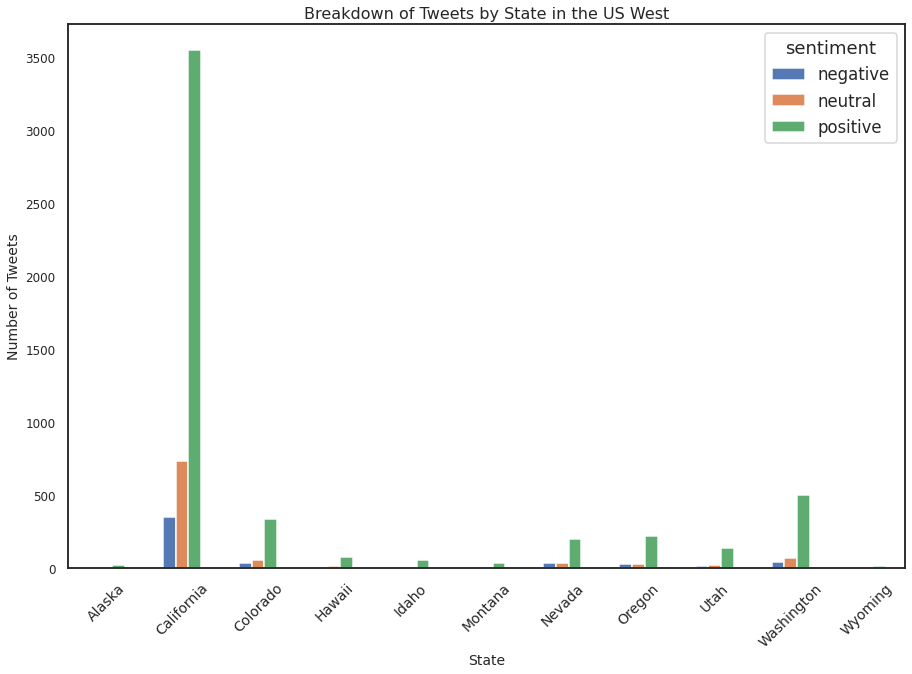

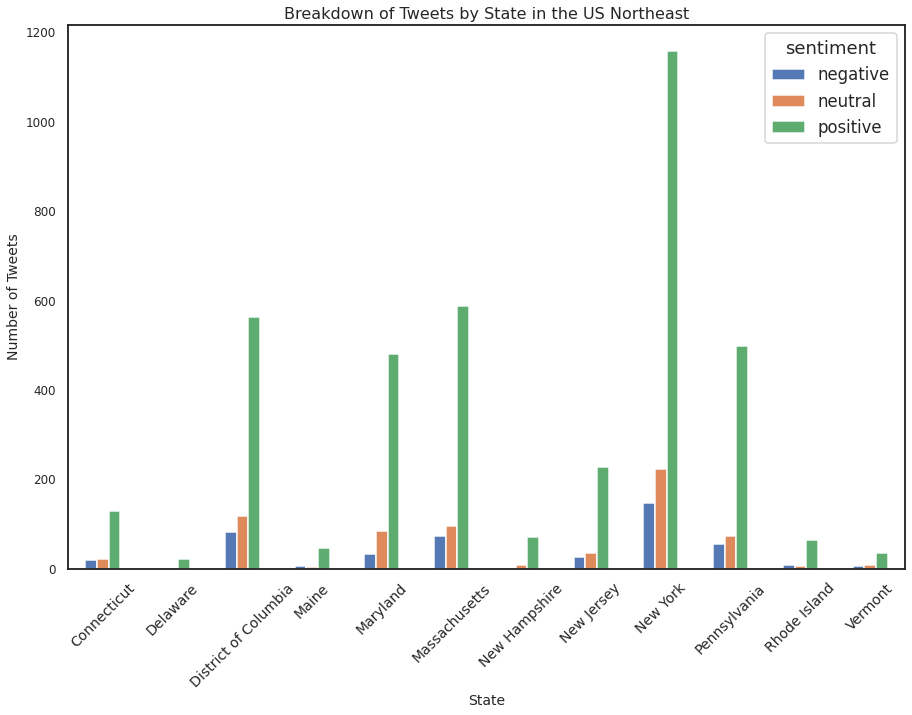

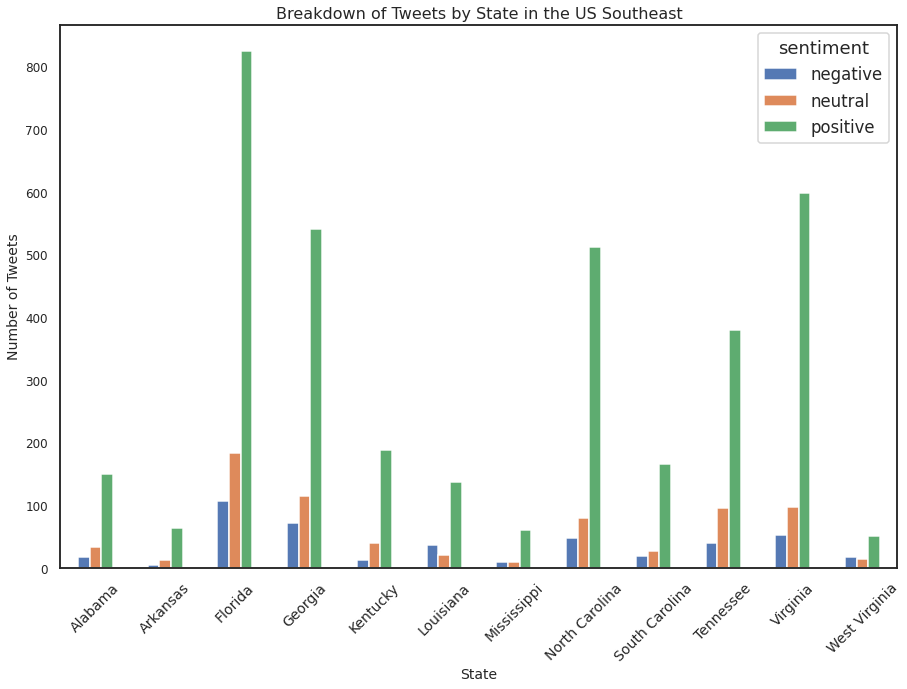

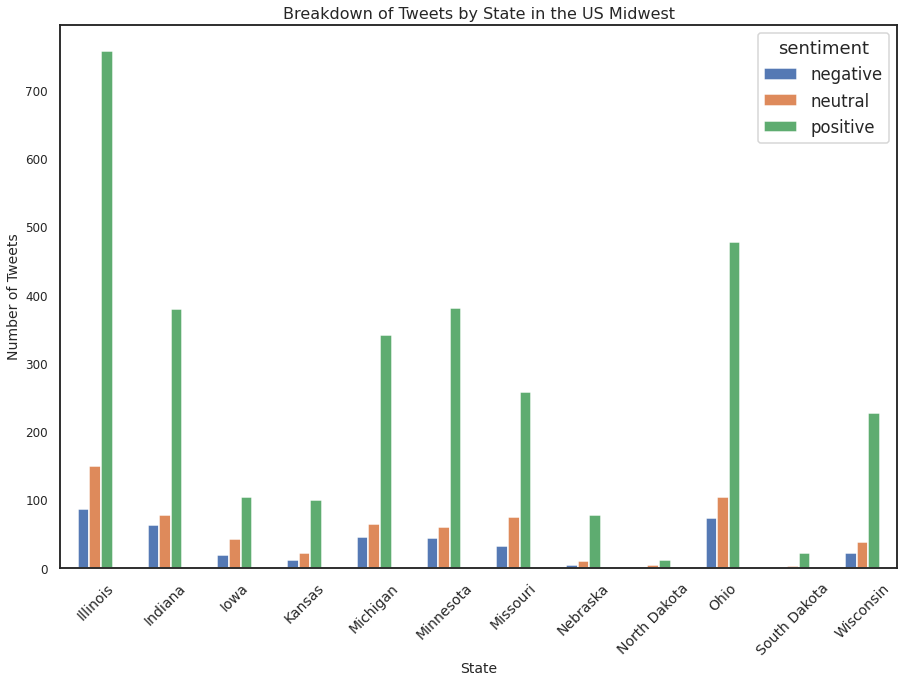

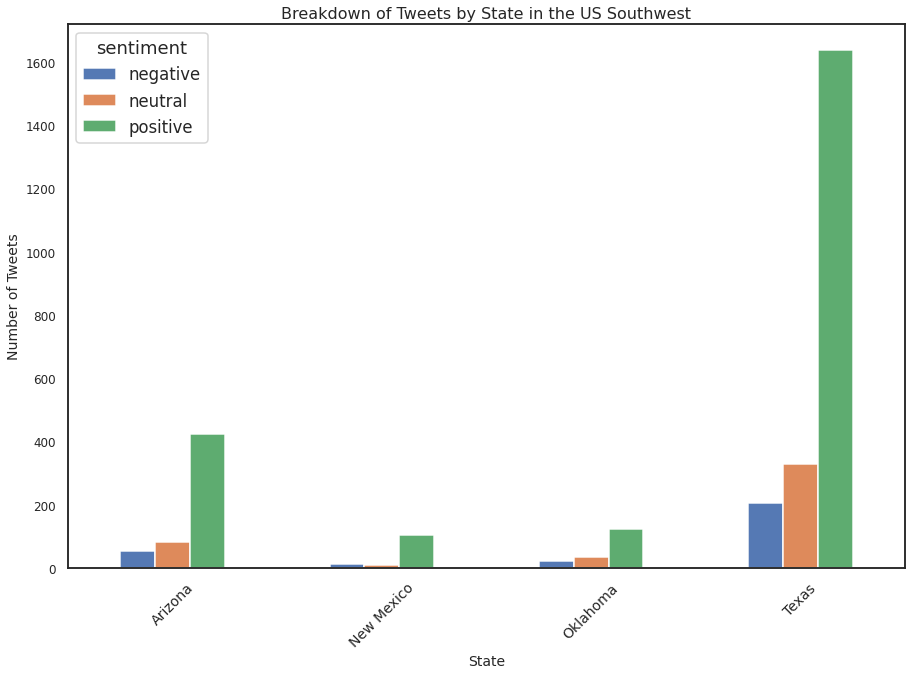

In [106]:
for item in regions_by_state_and_sentiment_groupbys:
    plot_region_breakdown(item, unstack=True)

## Question 3b: Insights/Recommendations:

ENTER